In [6]:
# Preparando o Notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

# 1. tabela fato
arquivo = "tabela_fato.xlsx"
df = pd.read_excel(arquivo)

print("✔ Arquivo lido com sucesso!")
print("Colunas:", df.columns.tolist())

✔ Arquivo lido com sucesso!
Colunas: ['ID', 'Hora de início', '0', 'Email', 'Nome', 'Hora da última modificação', 'EPS', 'Login do operador', 'Login do avaliador', 'Nº caso - SalesForce', 'ID Customer', 'Id da conversação', 'Data do contato', 'Possui gravação de tela?', 'Canal de atendimento', 'PagBank Chat', 'PagBank Voz', 'PagBank E-mail', 'PagBank Offline', 'Unidade de Negócio', 'Produto', 'Tema', 'Motivo do contato', 'Submotivo do contato', 'A tipificação está correta?', 'Qual a correta?', 'A transferência está correta?', 'Utilização da PagWiki', 'Matriz de Consequência Aplicável', 'Falhas Graves Generalista', 'Falhas Graves Reclame Aqui', 'Falhas Graves Bacen (RDR)', 'Falhas Graves Segurança', 'Nota de NPS atribuída pelo cliente', 'VOC (Voz do cliente)', 'Qual a insatisfação principal do cliente?', 'Qual o diagnóstico da nota', 'Atendimento', 'Bloqueios', 'Denúncia', 'Critérios de Segurança', 'Planos, Taxas e Juros', 'Processos logísticos', 'Prazos', 'Funcionalidades dos produtos/

In [12]:
# Volumetria NC e NCG
cond_falha_grave = df["Matriz de Consequência Aplicável"] != "Não houve sinalização de Falha Grave"

df["Flag_Falha_Grave"] = np.where(cond_falha_grave, "Falha Grave", "Falha Não Grave")

falhas_resumo = df["Flag_Falha_Grave"].value_counts(normalize=False).to_frame("Qtde")
falhas_resumo["%"] = (falhas_resumo["Qtde"] / falhas_resumo["Qtde"].sum() * 100).round(2)
falhas_resumo

,Qtde,%
Flag_Falha_Grave,,
Falha Não Grave,394,85.47
Falha Grave,67,14.53


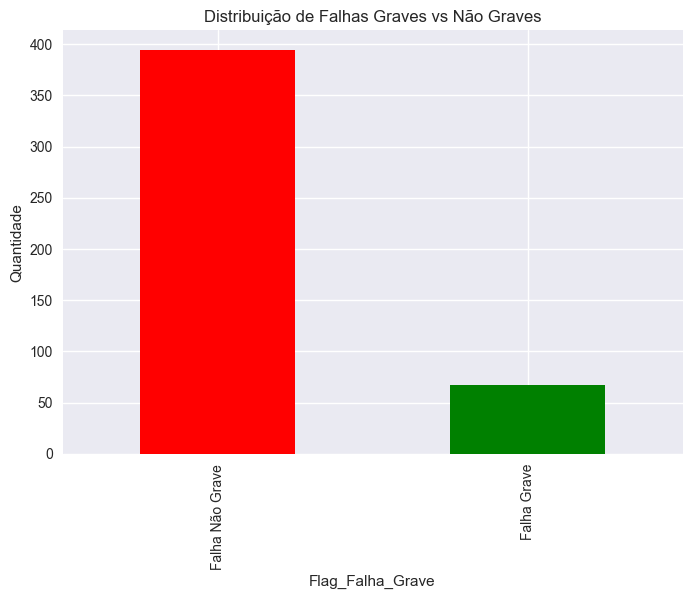

In [15]:
# Gráfico de NC e NCG
falhas_resumo["Qtde"].plot(kind="bar", color=["red", "green"])
plt.title("Distribuição de Falhas Graves vs Não Graves")
plt.ylabel("Quantidade")
plt.show()

C:\Users\jesse\AppData\Local\Temp\ipykernel_28328\3572255598.py:18: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jesse\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


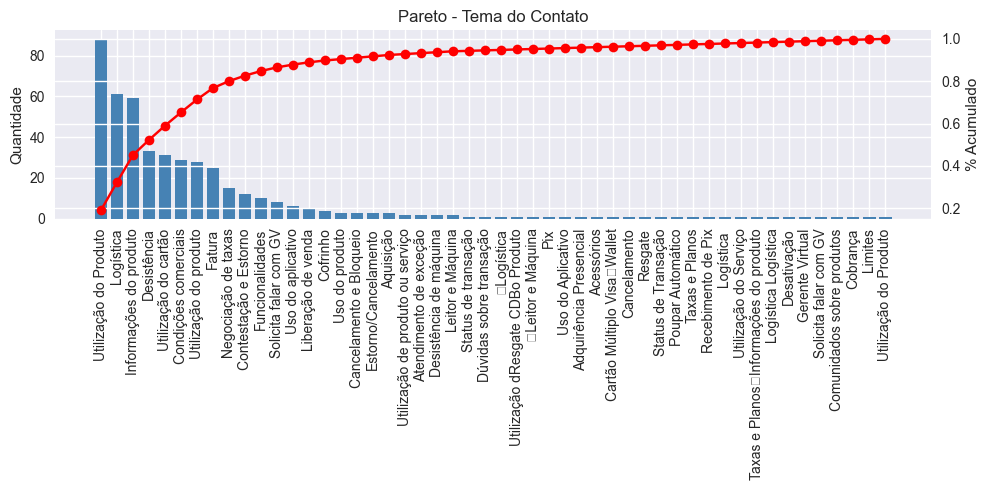

C:\Users\jesse\AppData\Local\Temp\ipykernel_28328\3572255598.py:18: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\jesse\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


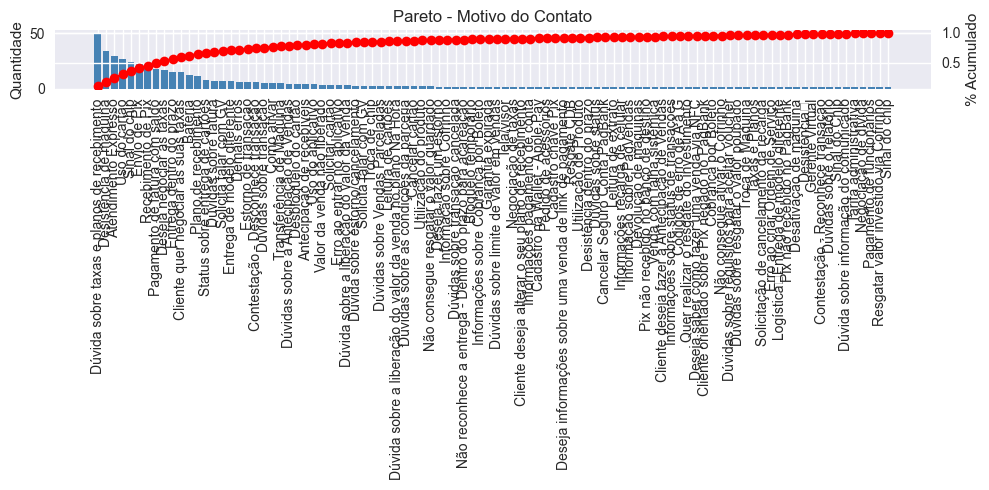

In [18]:
# Paretagem dos motivos
def pareto_plot(serie, titulo):
    contagem = serie.value_counts().reset_index()
    contagem.columns = ["Categoria", "Qtde"]
    contagem["%"] = contagem["Qtde"] / contagem["Qtde"].sum()
    contagem["% Acum"] = contagem["%"].cumsum()

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.bar(contagem["Categoria"], contagem["Qtde"], color="steelblue")
    ax1.set_ylabel("Quantidade")
    ax1.set_title(titulo)
    ax1.tick_params(axis="x", rotation=90)

    ax2 = ax1.twinx()
    ax2.plot(contagem["Categoria"], contagem["% Acum"], color="red", marker="o")
    ax2.set_ylabel("% Acumulado")

    plt.tight_layout()
    plt.show()
    return contagem

pareto_tema = pareto_plot(df["Tema"], "Pareto - Tema do Contato")
pareto_motivo = pareto_plot(df["Motivo do contato"], "Pareto - Motivo do Contato")

In [21]:
# Descobrando submotivo
submotivo_freq = df["Submotivo do contato"].value_counts().to_frame("Qtde")
submotivo_freq["%"] = (submotivo_freq["Qtde"] / submotivo_freq["Qtde"].sum() * 100).round(2)
submotivo_freq.head(20)

,Qtde,%
Submotivo do contato,,
Cliente orientado sobre as taxas e planos de recebimento,48,10.41
Não recebeu visita do técnico,26,5.64
Estorno dentro do prazo conforme forma de pagamento,18,3.90
Indisponibilidade no app,16,3.47
Status de entrega em andamento,13,2.82
Dúvidas sobre o plano,10,2.17
Estorno não recebido,9,1.95
Consulta de saldo disponível para uso,9,1.95
Solicita falar com GV,9,1.95


In [102]:
# Ensinando matirz de decisão: Selecionando colunas de motivo de sinalização (AL a AV) para modelagem
cols_motivo_sinalizacao = df.columns[37:49].tolist()
cols_motivo_sinalizacao

# Transformando em formato longo (melt)
df_melt = df.melt(
    id_vars=[
        "Unidade de Negócio",
        "Produto",
        "Motivo do contato",
        "Qual o diagnóstico da nota",
        "Login do operador",
        "Nº caso - SalesForce",
        "Atendimento"
    ],
    value_vars=cols_motivo_sinalizacao,
    var_name="Coluna_Motivo",
    value_name="Motivo_Sinalizacao"
)

df_melt = df_melt[df_melt["Motivo_Sinalizacao"].notna() & (df_melt["Motivo_Sinalizacao"] != "")]
df_melt.head()

,Unidade de Negócio,Produto,Motivo do contato,Qual o diagnóstico da nota,Login do operador,Nº caso - SalesForce,Atendimento,Coluna_Motivo,Motivo_Sinalizacao
24,Emissão,Cartão Múltiplo - Função débito,Uso do cartão,Bloqueios,ctx_larissa_98238,39727708,NaN,Bloqueios,Bloqueios Cartões
95,Emissão,Cartão de Crédito,Pagamento de fatura com saldo,Bloqueios,ctx_felipe_100724,40484337,NaN,Bloqueios,Bloqueios Cartões
213,Emissão,Cartão Múltiplo - Função Crédito,Pagamento de fatura com saldo,Bloqueios,ctx_aline_37126,41329693,NaN,Bloqueios,Bloqueios Cartões
215,Emissão,Cartão de Crédito,Pagamento de fatura com saldo,Bloqueios,ctx_helmiton_85081,41361024,NaN,Bloqueios,Bloqueios Cartões
218,PagBank,Cartão de Crédito,Pagamento de fatura com saldo,Bloqueios,ctx_cristiane_100645,41333691,NaN,Bloqueios,Bloqueios Cartões


In [105]:
# Criando o Pivot
matriz_decisao = pd.pivot_table(
    df_melt,
    index=[
        "Unidade de Negócio",
        "Produto",
        "Motivo do contato",
        "Qual o diagnóstico da nota",
        "Atendimento",
        "Motivo_Sinalizacao"
    ],
    values="Nº caso - SalesForce",
    aggfunc="nunique"
).reset_index().rename(columns={"Nº caso - SalesForce": "Qtde_Casos"})

matriz_decisao.head()

,Unidade de Negócio,Produto,Motivo do contato,Qual o diagnóstico da nota,Atendimento,Motivo_Sinalizacao


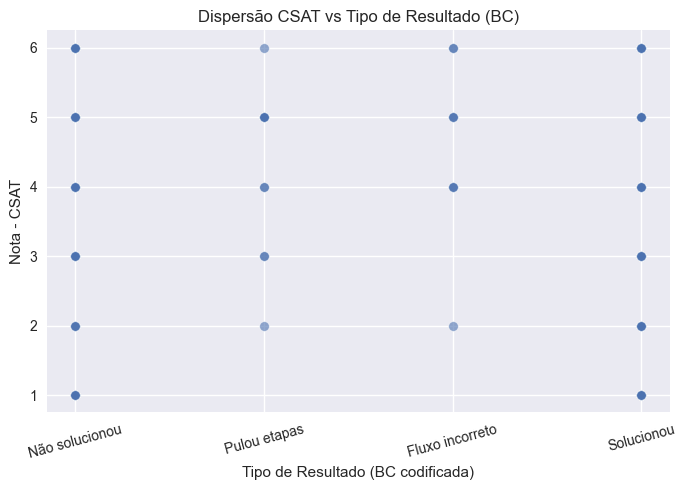

In [52]:
# Visibilidade de dispersão do rating

map_bc = {
    "Não solucionou a tratativa": 1,
    "Pulou etapas do processo": 2,
    "Seguiu o fluxo incorreto": 3,
    "Solucionou a tratativa": 4
}

# Nome real da coluna BC
col_bc = "IS - O atendimento foi solucionado na visão PagBank (Processual)"

# Criando coluna codificada
df["BC_cod"] = df[col_bc].map(map_bc)

# Filtrando apenas linhas válidas
df_disp = df.dropna(subset=["Nota - Csat", "BC_cod"])

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_disp, x="BC_cod", y="Nota - Csat", alpha=0.6)

plt.xticks([1,2,3,4], [
    "Não solucionou",
    "Pulou etapas",
    "Fluxo incorreto",
    "Solucionou"
], rotation=15)

plt.title("Dispersão CSAT vs Tipo de Resultado (BC)")
plt.ylabel("Nota - CSAT")
plt.xlabel("Tipo de Resultado (BC codificada)")
plt.tight_layout()
plt.show()

C:\Users\jesse\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.draw()
C:\Users\jesse\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


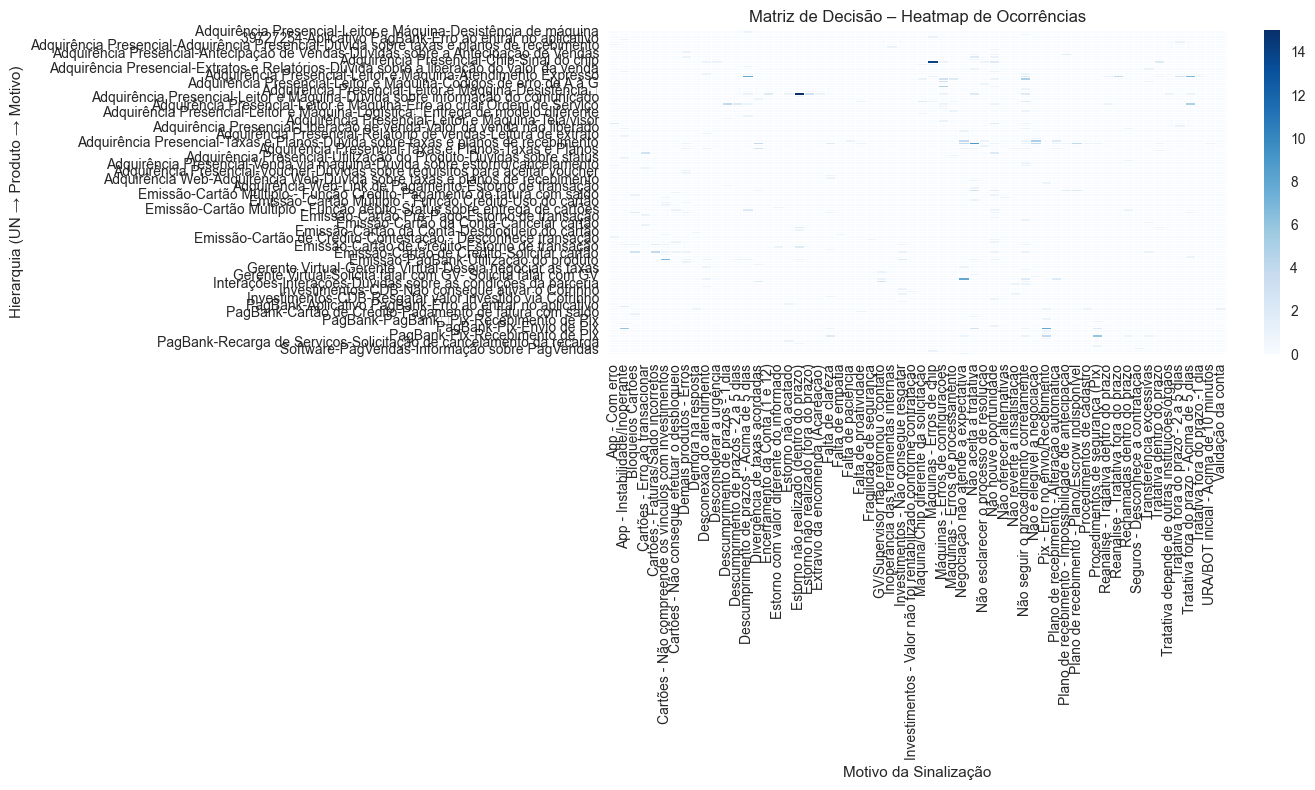

In [78]:
# Duplicando Pivot
pivot = matriz_decisao.pivot_table(
    index=["Unidade de Negócio", "Produto", "Motivo do contato"],
    columns="Motivo_Sinalizacao",
    values="Qtde_Casos",
    aggfunc="sum",
    fill_value=0
)
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap="Blues", linewidths=.5)
plt.title("Matriz de Decisão – Heatmap de Ocorrências")
plt.xlabel("Motivo da Sinalização")
plt.ylabel("Hierarquia (UN → Produto → Motivo)")
plt.tight_layout()
plt.show()

In [67]:
# Tokenização simples para interpretação Qualitativa de texto 
import re
from collections import Counter
from nltk.corpus import stopwords

import nltk
nltk.download("stopwords")

# Tratando a coluna String
textos = df["Resumo do atendimento"].dropna().astype(str).str.lower()

stopwords_pt = set(stopwords.words("portuguese"))

def limpar_texto_regex(t):
    # Tratamento: Mantém apenas letras e espaços
    t = re.sub(r"[^a-záéíóúâêôãõç\s]", " ", t)
    tokens = t.split()
    tokens = [tok for tok in tokens if tok not in stopwords_pt and len(tok) > 2]
    return tokens

tokens = []
for t in textos:
    tokens.extend(limpar_texto_regex(t))

freq = Counter(tokens)
freq_df = pd.DataFrame(freq.most_common(50), columns=["Palavra", "Frequência"])
freq_df.head(20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Palavra,Frequência
0,cliente,1435
1,especialista,786
2,contato,536
3,entrou,312
4,informa,272
5,pesquisa,269
6,atendimento,208
7,cartão,191
8,sobre,182
9,porem,182


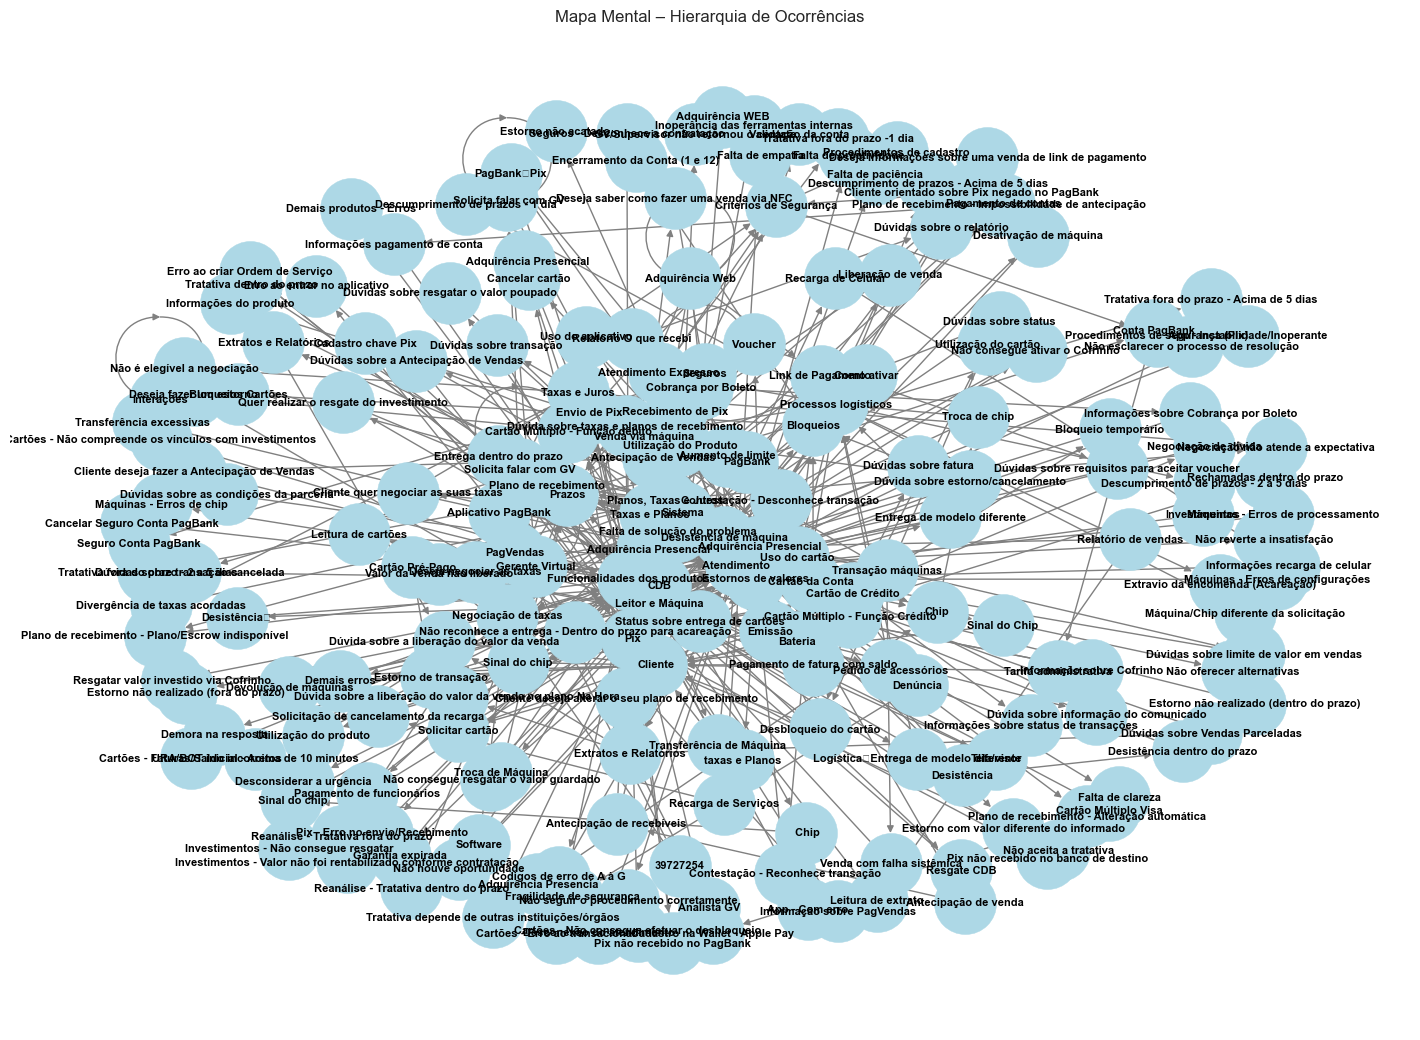

In [95]:
# Mapa mental totalizado
import networkx as nx

G = nx.DiGraph()

for _, row in matriz_decisao.iterrows():
    un = row["Unidade de Negócio"]
    prod = row["Produto"]
    motivo = row["Motivo do contato"]
    causa = row["Qual o diagnóstico da nota"]
    sinal = row["Motivo_Sinalizacao"]
    
    G.add_edge(un, prod)
    G.add_edge(prod, motivo)
    G.add_edge(motivo, causa)
    G.add_edge(causa, sinal)

plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
    edge_color="gray"
)

plt.title("Mapa Mental – Hierarquia de Ocorrências")
plt.show()

In [107]:
# Duplicando Pivot
matriz_decisao = pd.pivot_table(
    df_melt,
    index=[
        "Unidade de Negócio",
        "Produto",
        "Motivo do contato",
        "Qual o diagnóstico da nota",
        "Atendimento",
        "Motivo_Sinalizacao"
    ],
    values="Nº caso - SalesForce",
    aggfunc="nunique"
).reset_index().rename(columns={"Nº caso - SalesForce": "Qtde_Casos"})

In [118]:
df_filtrado = matriz_decisao[
    matriz_decisao["Atendimento"].notna() &
    (matriz_decisao["Atendimento"].astype(str).str.strip() != "")
]

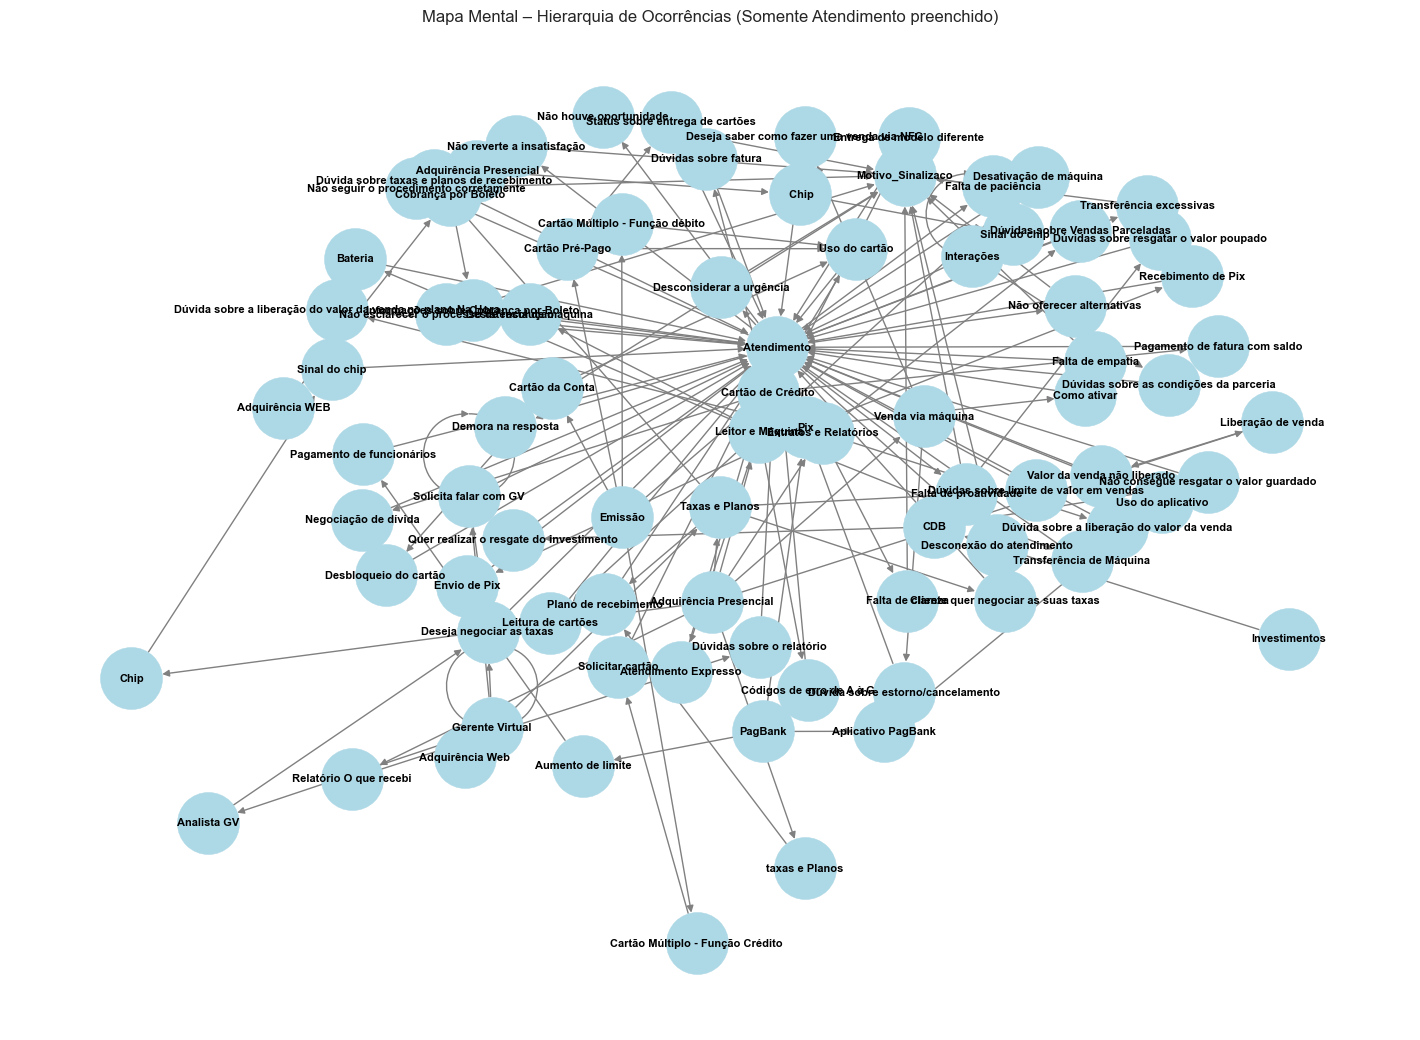

In [125]:
#Mapa mental trigger Atendimento
import networkx as nx
import matplotlib.pyplot as plt

# Filtrar linhas com Atendimento preenchido
df_filtrado = df[
    df["Atendimento"].notna() &
    (df["Atendimento"].astype(str).str.strip() != "")
]

# Criar grafo
G = nx.DiGraph()

for _, row in df_filtrado.iterrows():
    un = row["Unidade de Negócio"]
    prod = row["Produto"]
    motivo = row["Motivo do contato"]
    causa = row["Qual o diagnóstico da nota"]
    atendimento = row["Atendimento"]
    sinal = row["Motivo_Sinalizacao"] if "Motivo_Sinalizacao" in df.columns else "Motivo_Sinalizaco"
    
    G.add_edge(un, prod)
    G.add_edge(prod, motivo)
    G.add_edge(motivo, causa)
    G.add_edge(causa, atendimento)
    G.add_edge(atendimento, sinal)

# Plotar grafo
plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.5, seed=42)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
    edge_color="gray"
)

plt.title("Mapa Mental – Hierarquia de Ocorrências (Somente Atendimento preenchido)")
plt.show()

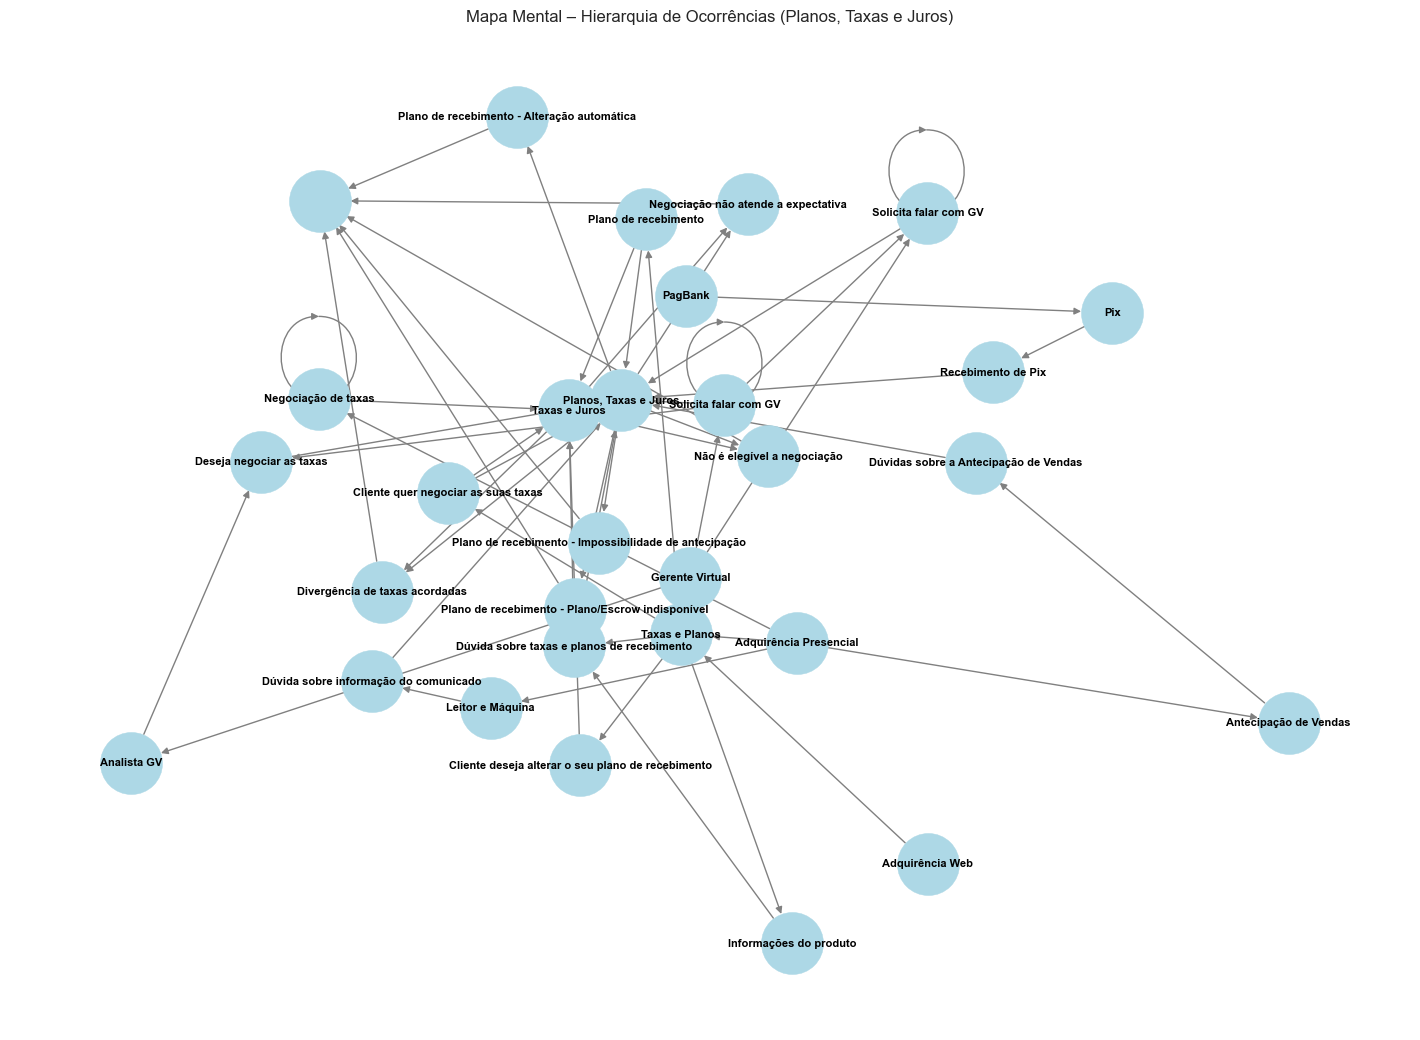

In [127]:
#Mapa mental trigger Planos
import networkx as nx
import matplotlib.pyplot as plt

# Nome da coluna de gatilho
col_trigger = "Planos, Taxas e Juros"

# Filtrar linhas com valor preenchido
df_ap = df[
    df[col_trigger].notna() &
    (df[col_trigger].astype(str).str.strip() != "")
]

# Criar grafo
G_ap = nx.DiGraph()

for _, row in df_ap.iterrows():
    un = row["Unidade de Negócio"]
    prod = row["Produto"]
    motivo = row["Motivo do contato"]
    causa = row["Qual o diagnóstico da nota"]
    trigger = row[col_trigger]
    sinal = row["Motivo_Sinalizacao"] if "Motivo_Sinalizacao" in df.columns else row.get("Motivo_Sinalizaco", "")

    G_ap.add_edge(un, prod)
    G_ap.add_edge(prod, motivo)
    G_ap.add_edge(motivo, causa)
    G_ap.add_edge(causa, trigger)
    G_ap.add_edge(trigger, sinal)

# Plotar grafo
plt.figure(figsize=(14,10))
pos = nx.spring_layout(G_ap, k=0.5, seed=42)

nx.draw(
    G_ap, pos,
    with_labels=True,
    node_size=2000,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
    edge_color="gray"
)

plt.title("Mapa Mental – Hierarquia de Ocorrências (Planos, Taxas e Juros)")
plt.show()

C:\Users\jesse\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


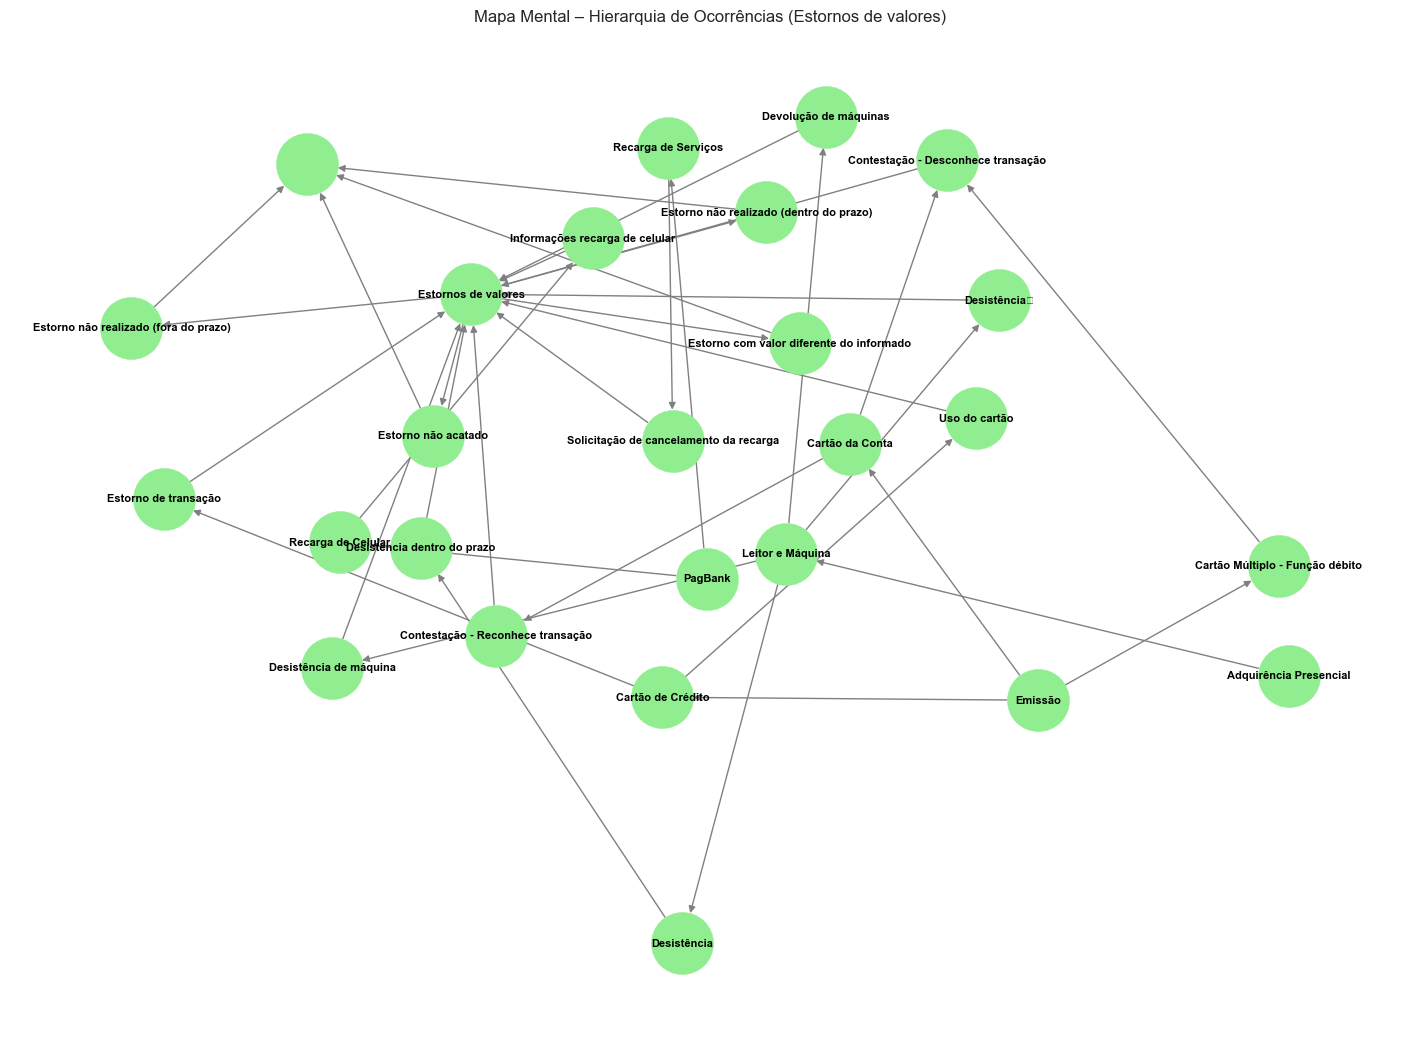

In [128]:
# #Mapa mental trigger Estorno
col_trigger = "Estornos de valores"

# Filtrar linhas com valor preenchido
df_at = df[
    df[col_trigger].notna() &
    (df[col_trigger].astype(str).str.strip() != "")
]

# Criar grafo
G_at = nx.DiGraph()

for _, row in df_at.iterrows():
    un = row["Unidade de Negócio"]
    prod = row["Produto"]
    motivo = row["Motivo do contato"]
    causa = row["Qual o diagnóstico da nota"]
    trigger = row[col_trigger]
    sinal = row["Motivo_Sinalizacao"] if "Motivo_Sinalizacao" in df.columns else row.get("Motivo_Sinalizaco", "")

    G_at.add_edge(un, prod)
    G_at.add_edge(prod, motivo)
    G_at.add_edge(motivo, causa)
    G_at.add_edge(causa, trigger)
    G_at.add_edge(trigger, sinal)

# Plotar grafo
plt.figure(figsize=(14,10))
pos = nx.spring_layout(G_at, k=0.5, seed=42)

nx.draw(
    G_at, pos,
    with_labels=True,
    node_size=2000,
    node_color="lightgreen",
    font_size=8,
    font_weight="bold",
    edge_color="gray"
)

plt.title("Mapa Mental – Hierarquia de Ocorrências (Estornos de valores)")
plt.show()